# Latent Dirichlet Allocation (LDA) with MALLET Results

The following notebook walks you through taking previously saved LDA Mallet models and cleaned data produced from the "ldaMalletCleanData" notebook in this repository and using the data to produce some bar graphs and several tables that are exported and can be used for further analysis. We do this to improve the reproducability of your results and increase efficiency by eliminating the need to repeat the entire process (which will create a slightly different model) if you decide you need to make changes to the visual output, but do not want the LDA model and topics to change. This notebook is where you would make changes that will impact the visual representation of the topics, but not the topics themselves.

###  Before we begin
Before we start, you will need to have set up a [Carbonate account](https://kb.iu.edu/d/aolp) in order to access [Research Desktop (ReD)](https://kb.iu.edu/d/apum). You will also need to have access to ReD through the [thinlinc client](https://kb.iu.edu/d/aput). If you have not done any of this, or have only done some of this, but not all, you should go to our [textPrep-Py.ipynb](https://github.com/cyberdh/Text-Analysis/blob/drafts/textPrep-Py.ipynb) before you proceed further. The textPrep-Py notebook provides information and resources on how to get a Carbonate account, how to set up ReD, and how to get started using the Jupyter Notebook on ReD.

### Run CyberDH environment
The code in the cell below points to a Python environment specificaly for use with the Python Jupyter Notebooks created by Cyberinfrastructure for Digital Humanities. It allows for the use of the different pakcages in our notebooks and their subsequent data sets.

##### Packages
- **sys:** Provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter. It is always available.
- **os:** Provides a portable way of using operating system dependent functionality.

#### NOTE: This cell is only for use with Research Desktop. You will get an error if you try to run this cell on your personal device!!

In [1]:
import sys
import os
sys.path.insert(0,"/N/u/cyberdh/Carbonate/dhPyEnviron/lib/python3.6/site-packages")
os.environ["NLTK_DATA"] = "/N/u/cyberdh/Carbonate/dhPyEnviron/nltk_data"

Python's extensibility comes in large part from packages. Packages are groups of functions, data, and algorithms that allow users to easily carry out processes without recreating the wheel. Some packages are included in the basic installation of Python, others created by Python users are available for download.

In your terminal, packages can be installed by typing `pip install nameofpackage --user`. However, since you are using ReD and our Python environment, you will not need to install any of the packages below to use this notebook. Anytime you need to make use of a package, however, you need to import it so that Python knows to look in these packages for any functions or commands you use. Below is a brief description of the packages we are using in this notebook:  

- **pandas:** An open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
- **glob:** Finds all the pathnames matching a specified pattern according to the rules used by the Unix shell.
- **seaborn:** A Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.
- **matplotlib:**  Produces publication quality 2D graphics for interactive graphing, scientific publishing, user interface development and web application servers targeting multiple user interfaces and hardcopy output formats.
- **gensim:** Python library for topic modelling, document indexing and similarity retrieval with large corpora.
- **pickle:** Implements binary protocols for serializing and de-serializing a Python object structure. "Pickling" is the process whereby a Python object hierarchy is converted into a byte stream, and "unpickling" is the inverse operation, whereby a byte stream (from a binary file or bytes-like object) is converted back into an object hierarchy.
- **logging:** Defines functions and classes which implement a flexible event logging system for applications and libraries.
- **warnings:** Allows for the manipulation of warning messages in Python.

Notice we import some of the packages differently. In some cases we just import the entire package when we say `import XYZ`. For some packages which are small, or, from which we are going to use a lot of the functionality it provides, this is fine. 

Sometimes when we import the package directly we say `import XYZ as X`. All this does is allow us to type `X` instead of `XYZ` when we use certain functions from the package. So we can now say `X.function()` instead of `XYZ.function()`. This saves time typing and eliminates errors from having to type out longer package names. I could just as easily type `import XYZ as potato` and whenever I use a function from the `XYZ` package I would need to type `potato.function()`. What we import the package as is up to you, but some commonly used packages have abbreviations that are standard amongst Python users such as `import pandas as pd` or `import matplotlib.pyplot as plt`. You do not need to us `pd` or `plt`, however, these are widely used and using something else could confuse other users and is generally considered bad practice. 

Other times we import only specific elements or functions from a package. This is common with packages that are very large and provide a lot of functionality, but from which we are only using a couple functions or a specific subset of the package that contains the functionality we need. This is seen when we say `from XYZ import ABC`. This is saying I only want the `ABC` function from the `XYZ` package. Sometimes we need to point to the specific location where a function is located within the package. We do this by adding periods in between the directory names, so it would look like `from XYZ.123.A1B2 import LMN`. This says we want the `LMN` function which is located in the `XYZ` package and then the `123` and `A1B2` directory in that package. 

You can also import more than one function from a package by separating the functions with commas like this `from XYZ import ABC, LMN, QRS`. This imports the `ABC`, `LMN` and `QRS` functions from the `XYZ` package.

In [2]:
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from gensim import corpora, models
import pickle

# Import warning
import logging
import warnings

This will give more details regarding error messages and will also ignore deprecation and user warnings. All the deprecation and user warnings in this code are not concerning and will not break the code or cause errors in the results.

In [3]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=UserWarning)
warnings.filterwarnings("ignore",category=FutureWarning)
warnings.filterwarnings("ignore",category=RuntimeWarning)

### Getting your data

#### File paths
Here we are saving as variables different file paths that we need in our code. We do this so that they are easier to call later and so that you can make most of your changes now and not need to make as many changes later. 

First we use the `os` package above to find our `[HOME]` directory using the `environ` function. This will work for any operating system, so if you decide to try this out on your personal computer instead of ReD, the `homePath` variable will still be the path to your "home" directory, so no changes are needed.

Next, we combine the `homePath` variable with the folder names that lead to where our original data is stored. We may need this so we can use the filenames in this directory later to create some of our tables. This will only be necessary if we set the `docLevel` variable to **True** down below. We save the path as a variable named `dataHome`.

Then we combine the `homePath` variable with the folder names that lead to where our data cleaned by the "ldaMalletCleanData" is stored. We assign the path to the variable `dataCleaned`.

Now we add the `homePath` variable to other folder names that lead to a folder where we will want to save any output generated by this code. We will change the file names for our output in other cells as we need to down below. We save this file path as the variable `dataResults`.

Lastly, we add the `dataCleaned` variable to the file names for the cleaned files we need to visualize our LDA topics. We assign these files to the variables `cleanDict` (dictionary), `cleanData` (list of cleaned words from data), `cleanModel` (LDA model), and `origData` (list of words that have not been cleaned from original data). Make sure the file name in quotes matches the name of the file created by the "ldaMalletCleanData" notebook.

In [4]:
homePath = os.environ["HOME"]
dataHome = os.path.join(homePath, "Text-Analysis-master", "data")
dataCleaned = os.path.join(homePath, "Text-Analysis-master", "TopicModeling", "LDA", "cleanedData")
dataResults = os.path.join(homePath, "Text-Analysis-master", "Output")
cleanDict = os.path.join(dataCleaned, "ldaDict")
cleanData = os.path.join(dataCleaned, "ldaDataClean")
cleanModel = os.path.join(dataCleaned, "ldaModel")
origData = os.path.join(dataCleaned, "ldaDataOrig")

### Set Variables

The `docLevel` variable needs to be set to either **True** or **False**. It also needs to match what the setting of the `docLevel` variable from the "ldaMalletCleanData" notebook was set to when it cleaned the data currently being loaded by this notebook. If the two variables do not match then it will create incomplete data as well as result in an infinite loop at the end of the notebook and, therefore, will not produce the final bar graphs.

The `paths` variable is assigned a file path that leads to the folder containing your original text files. Adjust the path as needed, however, this path only needs to be changed if the `docLevel` variable is **True** and your data files are stored in a different location then where the path currently points.

In [5]:
docLevel = True
paths = glob.glob(os.path.join(dataHome, "shakespeareFolger", "*.txt"))

#### Load cleaned data

Here we load in the data cleaned by the "ldaMalletCleanData" notebook. We start by loading in our gensim dictionary and assigning it to the variable `id2word`. Then we load in our LDA model and assign it to the variable `optimalModel`. Next, using the "pickle" package, we read in a list of the words contained in our original data that have not been cleaned and assign it to the variable `data`. Lastly, we read in a list of the cleaned words from our original data using the "pickle" package and assign them to the variable `texts`.

In [6]:
id2word = corpora.dictionary.Dictionary.load(cleanDict)
optimalModel = models.LdaModel.load(cleanModel)
with open(origData, "rb") as sd:
    data = pickle.load(sd)
with open(cleanData, "rb") as file:
    texts = pickle.load(file)

This line of code uses the list of words in `id2word`, performs the `doc2bow` function on the dictionary and uses the `texts` list of words to get a sparse representation of the word counts. This is in a vector format, so it converts the words into two numbers like this: (2,1). The first number is the word id and the second number is the word frequency. This was needed to create the LDA model, and is needed again to make sense of the model in order to create our tables and graphs below.

In [7]:
corpus = [id2word.doc2bow(text) for text in texts]

### Finding the dominant topic in each chunk

One of the practical applications of topic modeling is to take a chunk and determine what the dominant topic is for that chunk. To find that, we find the topic number that has the highest percentage contribution in that chunk. The `format_topics_sentences()` function below aggregates this information in a presentable table.

The table created gives the file name (but only if you set `docLevel` to **True** above), topic number of the most dominant topic for the chunk, percent contribution of that topic to that chunk, the keywords of the topic, and the beginning text of the chunk.

In [8]:
def formatTopicsSentences(ldamodel=optimalModel, corpus=corpus, texts=data):
    # Init output
    
    sentTopicsDf = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topicNum, propTopic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topicNum)
                topicKeywords = ", ".join([word for word, prop in wp])
                sentTopicsDf = sentTopicsDf.append(pd.Series([int(topicNum), round(propTopic,4), topicKeywords]), ignore_index=True)
            else:
                break
    sentTopicsDf.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    if docLevel is True:
        txtPaths = pd.Series(os.path.basename(pathName) for pathName in paths)

        textPath = pd.Series(txtPaths)
        contents = pd.Series(texts)
        sentTopicsDf = pd.concat([textPath, sentTopicsDf, contents], axis=1)
        return(sentTopicsDf)
    else:
        contents = pd.Series(texts)
        sentTopicsDf = pd.concat([sentTopicsDf, contents], axis=1)
        return(sentTopicsDf)

Now we apply the function we just created. The only part of this you will need to change is the file name of the .csv file output of this table. This can be found in the beginning of the cell and is saved as the variable `domTopicPerChunkCSV`. Change the name of the file in quotes to whatever makes sense to you and fits your data.

If `docLevel` was set to **True** above then the code will add a column to the data frame for the file names. If it was set to **False** then it will not.

In [9]:
domTopicPerChunkCSV = 'domTopicPerChunk.csv'

dfTopicSentsKeywords = formatTopicsSentences(ldamodel=optimalModel, corpus=corpus, texts=data)

# Format
dfDominantTopic = dfTopicSentsKeywords.reset_index(drop=True)
if docLevel is True:
    dfDominantTopic.columns = ['Filename', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
else:
    dfDominantTopic.columns = ['Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

    
dfDominantTopic.to_csv(os.path.join(dataResults, domTopicPerChunkCSV))
# Show
dfDominantTopic.head(10)

Filename  Dominant_Topic  Topic_Perc_Contrib  \
0            KingLear.txt             7.0              0.1653   
1        KingHenry6_1.txt             8.0              0.2397   
2    TamingOfTheShrew.txt             9.0              0.2824   
3     TitusAndronicus.txt             0.0              0.2660   
4          KingHenry8.txt             5.0              0.1803   
5    MerchantOfVenice.txt            19.0              0.2328   
6          KingHenry5.txt            18.0              0.1645   
7             Tempest.txt            14.0              0.1680   
8  TroilusAndCressida.txt             6.0              0.2635   
9        KingRichard2.txt             3.0              0.2353   

                                            Keywords  \
0  lord, man, fortune, friend, fool, nature, nobl...   
1  france, king, henry, lord, warwick, england, d...   
2  father, love, daughter, master, young, woman, ...   
3  romeo, rome, son, lord, emperor, brother, swee...   
4  king, lord, queen, grace, son, noble, father, ...   
5  wife, master, ring, home, house, money, jew, b...   
6  man, good, time, day, true, god, speak, lie, h...   
7  eye, play, hamlet, monster, lord, follow, nigh...   
8  hector, lord, troilus, fool, achille, troy, gr...   
9  lord, king, god, grace, edward, brother, richa...   

                                                Text  
0  [ I thought the King had more affected the Duk...  
1  [ Hung be the heavens with black, yield day to...  
2  [ I'll feeze you, in faith.,  A pair of stocks...  
3  [ Noble patricians, patrons of my right,,  Def...  
4  [ I come no more to make you laugh. Things now...  
5  [ In sooth I know not why I am so sad.,  It we...  
6  [ O, for a muse of fire that would ascend,  Th...  
7  [ Boatswain!,  Here, master. What cheer?,  Goo...  
8  [ In Troy there lies the scene. From isles of ...  
9  [ Old John of Gaunt, time-honored Lancaster,, ...

### Find the most representative chunk for each topic

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the chunk a given topic has contributed to the most and infer the topic by reading that chunk. The table created gives the chunk that is most representative of the topic, the topic number, percent contribution of that topic to that dchunk, the keywords of the topic, and the beginning text of the chunk.

The only part of this you will need to change is the file path where the .csv file output of this table will be saved. This can be found in the beginning of the cell and is saved as the variable `chunkRepCSV`. Change the name of the file in quotes to whatever makes the most sense for you and your data.

Again, if `docLevel` was set to **True** above then the code will add a column to the data frame for the file names. If it was set to **False** then it will not.

In [10]:
chunkRepCSV = 'chunkRepPerTopic.csv'

# Group top 5 sentences under each topic
sentTopicsSorteddfMallet = pd.DataFrame()

sentTopicsOutdfGrpd = dfTopicSentsKeywords.groupby('Dominant_Topic')

for i, grp in sentTopicsOutdfGrpd:
    sentTopicsSorteddfMallet = pd.concat([sentTopicsSorteddfMallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sentTopicsSorteddfMallet.reset_index(drop=True, inplace=True)

# Format
if docLevel is True:
    sentTopicsSorteddfMallet.columns = ['Filename','Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
else:
    sentTopicsSorteddfMallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
    
sentTopicsSorteddfMallet.to_csv(os.path.join(dataResults, chunkRepCSV))

# Show
sentTopicsSorteddfMallet

Filename  Topic_Num  Topic_Perc_Contrib  \
0        TitusAndronicus.txt        0.0              0.2660   
1             Coriolanus.txt        1.0              0.1966   
2      MeasureForMeasure.txt        2.0              0.3088   
3           KingRichard3.txt        3.0              0.2452   
4    MerryWivesOfWindsor.txt        4.0              0.3325   
5            WintersTale.txt        5.0              0.2146   
6     TroilusAndCressida.txt        6.0              0.2635   
7          TimonOfAthens.txt        7.0              0.2623   
8           KingHenry6_1.txt        8.0              0.2397   
9       TamingOfTheShrew.txt        9.0              0.2824   
10              KingJohn.txt       10.0              0.2526   
11        RomeoAndJuliet.txt       11.0              0.2098   
12               Macbeth.txt       12.0              0.2421   
13  TwoGentlemenOfVerona.txt       13.0              0.3004   
14  MidsummerNightsDream.txt       14.0              0.2660   
15      LovesLaboursLost.txt       15.0              0.3084   
16          KingHenry4_1.txt       16.0              0.2053   
17          JuliusCaesar.txt       17.0              0.2636   
18   MuchAdoAboutNothing.txt       18.0              0.2116   
19        ComedyOfErrors.txt       19.0              0.2695   

                                             Keywords  \
0   romeo, rome, son, lord, emperor, brother, swee...   
1   good, great, hear, leave, bring, speak, pray, ...   
2   lord, brother, die, duke, death, claudio, plac...   
3   lord, king, god, grace, edward, brother, richa...   
4   cassio, master, wife, good, husband, pray, her...   
5   king, lord, queen, grace, son, noble, father, ...   
6   hector, lord, troilus, fool, achille, troy, gr...   
7   lord, man, fortune, friend, fool, nature, nobl...   
8   france, king, henry, lord, warwick, england, d...   
9   father, love, daughter, master, young, woman, ...   
10  blood, hand, peace, arm, mother, son, bear, to...   
11  father, art, life, word, hast, stand, dead, lo...   
12  make, speak, night, lie, thing, fear, hold, ha...   
13  love, make, lady, eye, fair, heart, madam, fri...   
14  eye, play, hamlet, monster, lord, follow, nigh...   
15  love, sweet, lord, wit, fair, faith, hand, wor...   
16  prince, master, horse, harry, peace, cousin, j...   
17  caesar, rome, brutus, antony, noble, friend, p...   
18  man, good, time, day, true, god, speak, lie, h...   
19  wife, master, ring, home, house, money, jew, b...   

                                                 Text  
0   [ Noble patricians, patrons of my right,,  Def...  
1   [ Before we proceed any further, hear me,  spe...  
2   [ Escalus.,  My lord., ,  Of government the pr...  
3   [ Now is the winter of our discontent,  Made g...  
4   [ Sir Hugh, persuade me not. I will make a,  S...  
5   [ If you shall chance, Camillo, to visit Bohem...  
6   [ In Troy there lies the scene. From isles of ...  
7   [ Good day, sir.,  I am glad you're well., ,  ...  
8   [ Hung be the heavens with black, yield day to...  
9   [ I'll feeze you, in faith.,  A pair of stocks...  
10  [ Now say, Chatillion, what would France with ...  
11  [ Two households, both alike in dignity,  (In ...  
12  [ When shall we three meet again?,  In thunder...  
13  [ Cease to persuade, my loving Proteus.,  Home...  
14  [ Now, fair Hippolyta, our nuptial hour,  Draw...  
15  [ Let fame, that all hunt after in their lives...  
16  [ So shaken as we are, so wan with care,,  Fin...  
17  [ Hence! Home, you idle creatures, get you hom...  
18  [ I learn in this letter that Don,  Pedro of A...  
19  [ Proceed, Solinus, to procure my fall,,  And ...

### Topic distribution across chunks

Next we want to understand the volume and distribution of topics in order to judge how widely it occurs in our data. The below table displays that information. 

This table tells the topic number, the topic keywords, the number of chunks that had this topic as its dominant topic, and what percent of the total number of chunks had this topic as the dominant topic.

The only part of this you will need to change is the file path where the .csv file output of this table will be saved. This can be found in the beginning of the cell and is saved as the variable `topicDistCSV`. Change the name of the file in quotes to whatever makes sense for you and your data.

In [11]:
topicDistCSV = 'domTopicCount.csv'

# Number of Documents for Each Topic
topicCounts = dfTopicSentsKeywords.groupby(['Dominant_Topic','Topic_Keywords']).size().to_frame('Num_Documents').reset_index()

# Percentage of Documents for Each Topic
topicContribution = round(topicCounts['Num_Documents']/topicCounts['Num_Documents'].sum(), 4)

# Concatenate Column wise
dfDominantTopics = pd.concat([topicCounts, topicContribution], axis=1)

# Change Column names
dfDominantTopics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']
dfDominantTopics.to_csv(os.path.join(dataResults, topicDistCSV))
# Show
dfDominantTopics

Dominant_Topic                                     Topic_Keywords  \
0              0.0  romeo, rome, son, lord, emperor, brother, swee...   
1              1.0  good, great, hear, leave, bring, speak, pray, ...   
2              2.0  lord, brother, die, duke, death, claudio, plac...   
3              3.0  lord, king, god, grace, edward, brother, richa...   
4              4.0  cassio, master, wife, good, husband, pray, her...   
5              5.0  king, lord, queen, grace, son, noble, father, ...   
6              6.0  hector, lord, troilus, fool, achille, troy, gr...   
7              7.0  lord, man, fortune, friend, fool, nature, nobl...   
8              8.0  france, king, henry, lord, warwick, england, d...   
9              9.0  father, love, daughter, master, young, woman, ...   
10            10.0  blood, hand, peace, arm, mother, son, bear, to...   
11            11.0  father, art, life, word, hast, stand, dead, lo...   
12            12.0  make, speak, night, lie, thing, fear, hold, ha...   
13            13.0  love, make, lady, eye, fair, heart, madam, fri...   
14            14.0  eye, play, hamlet, monster, lord, follow, nigh...   
15            15.0  love, sweet, lord, wit, fair, faith, hand, wor...   
16            16.0  prince, master, horse, harry, peace, cousin, j...   
17            17.0  caesar, rome, brutus, antony, noble, friend, p...   
18            18.0  man, good, time, day, true, god, speak, lie, h...   
19            19.0  wife, master, ring, home, house, money, jew, b...   

    Num_Documents  Perc_Documents  
0               1          0.0278  
1               3          0.0833  
2               1          0.0278  
3               3          0.0833  
4               1          0.0278  
5               2          0.0556  
6               1          0.0278  
7               2          0.0556  
8               2          0.0556  
9               1          0.0278  
10              1          0.0278  
11              1          0.0278  
12              3          0.0833  
13              2          0.0556  
14              2          0.0556  
15              1          0.0278  
16              2          0.0556  
17              2          0.0556  
18              3          0.0833  
19              2          0.0556

### Distribution of each topic across each chunk

This code creates a table that shows each document as well as the percentage of each topic within that document. This will only be implemented if `docLevel` was set to **True** above as it is really only useful at the document level.

There are two lines where changes will need to be made. They both follow directly after the commented line `#Variables`. The first line determines the name of the output .csv file that this table will be saved as. This is saved as the variable `docTopicsCSV`. Change the name of the file in quotes to whatever makes sense for you and your data. 

In the `sortOrder` variable you will need to change the `'topic_x'` to match whatever topic you wish to have the table orderd by (replacing the 'x' with the number of the topic, so `'topic_12'` or `'topic_0'`). This will allow you to see which documents in descending order have the highest percentage of your topic of interest. The syntax for the topic will always be `'topic_x'` as it is going by the column header. If you want it ordered by file name then put the `'Filenames'` column header first. The primary order will be by which ever column header comes first, with the second column header being a secondary ordering option. This means if we order it by `'topic_5'` first and then by `'Filnames'` second, the data frame rows will be in descending order based on the numbers in the column labeled `'topic_5'`, but in any cases where the numbers in `'topic_5'` are identical it will order those identical numbers by the corresponding contents of the `'Filenames'` column.

Again, this is only if you set `docLevel` to **True** above. The .csv file will contain the data based on the column you chose in the `sortOrder` variable. So the data will be sorted according to what topic (or the Filenames) you specified from the highest score to the lowest.

In [12]:
if docLevel is True:
    #Variables
    docTopicsCSV = 'docTopics.csv'
    sortOrder = ['topic_0','Filenames']
    
    docTopics = []
    for i in range(len(texts)):
        docTopics.append(optimalModel[corpus[i]])


    topicSeriesDf = pd.DataFrame([[y[1] for y in  x] for x in docTopics])


    txtPaths = pd.Series(os.path.basename(pathName) for pathName in paths)

    textPath = pd.Series(txtPaths)
    contents = pd.Series(texts)
    docTopicDis = pd.concat([textPath, topicSeriesDf], axis=1)

    docTopicsDf = docTopicDis.reset_index(drop = True)
    # get length of df's columns
    numCols = len(list(docTopicsDf))

    rng = range(0, (numCols) + 1)

    newCols = ['Filenames'] + ['topic_' + str(i) for i in rng]

    # ensure the length of the new columns list is equal to the length of df's columns
    docTopicsDf.columns = newCols[:numCols]

    sortedDf = docTopicsDf.sort_values(sortOrder, ascending = False)
    sortedDf.to_csv(os.path.join(dataResults, docTopicsCSV))

    sortedDf
else:
    None

### Plot a stacked bar graph

This stacked bar graph shows the distribution of topics within a document. This will only be run if `docLevel` was set to **True** above as it is really only useful at the document level. That said, there are a few places where changes might need to be made. These can all be found in the four lines after the `#Variables` line. 

1. In the `graphName` variable you will want to change the name of the .png file to a name that fits better with your dataset.

2. The `boxSize` variable changes the size and dimensions of the legend box. The numbers indicate the following: (x, y, width, height). So the first two numbers determine where the legend resides in relation to the graph, and the third and fourth numbers determine how wide and high the legend box is. Feel free to play with these numbers to better fit your graph if needed.

3. In the `colorScheme` variable you may wish to change the color from `"tab20"` to a different color scheme. Some options can be found [here](https://matplotlib.org/users/colormaps.html).

4. The next line which is the variable `topN` you may want to change the number depending on how many documents you wish to see. Right now we are diplaying the top 10, but you may only want 5 or 20. Adjust this number accordingly.

The rest of the code should not need to be adjusted.

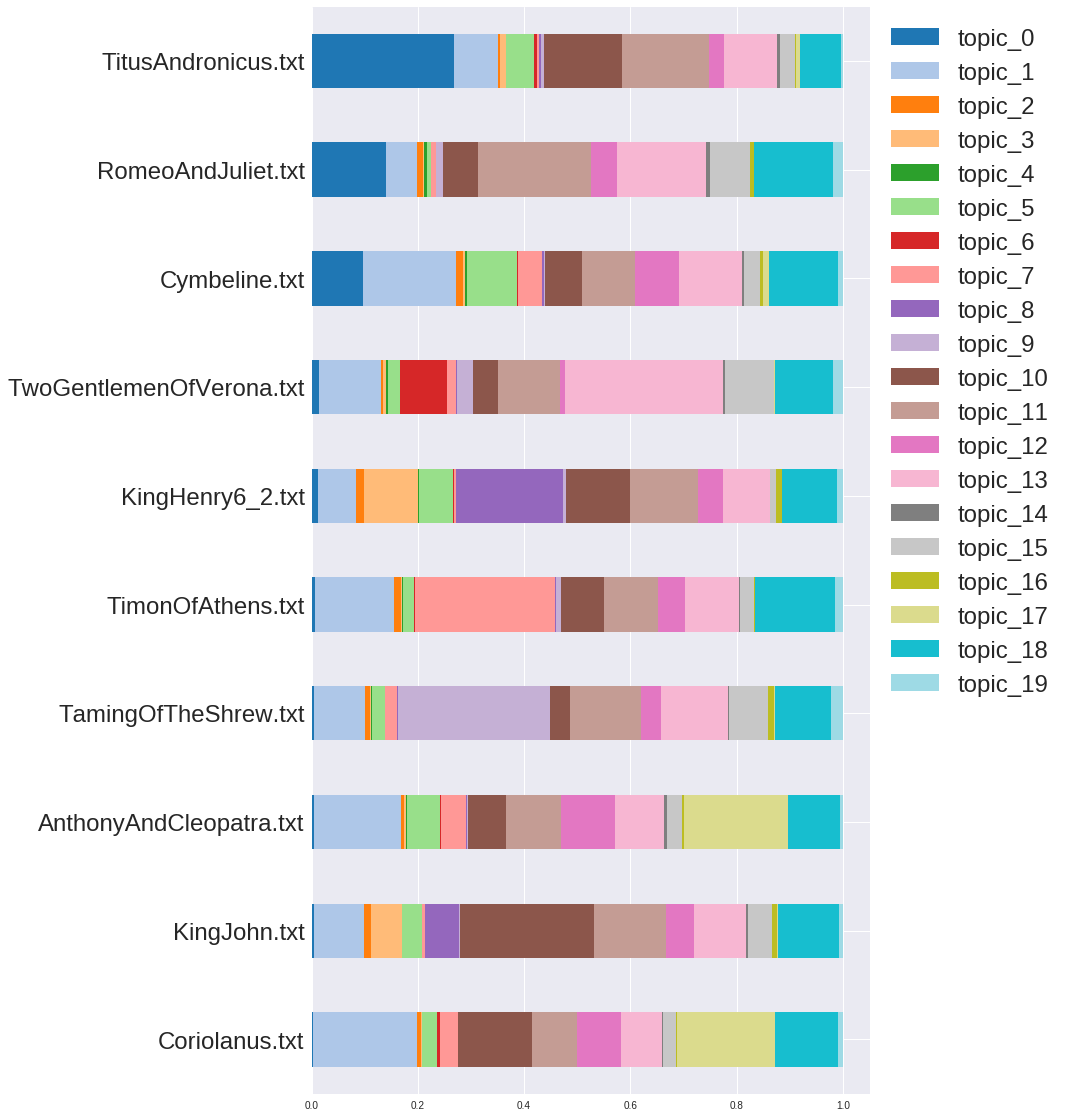

In [13]:
if docLevel is True:
    
    #Variables
    graphName = 'stackedBarGraphLDA.png'
    boxSize = (1.01,.5,.35,.5)
    colorScheme = "tab20"
    topN = min(10, len(sortedDf))
    colors = plt.cm.get_cmap(colorScheme)
    sortedDfSh = sortedDf[:topN]
    sortedDfSh = sortedDfSh.iloc[::-1]
    ax = sortedDfSh.plot(kind='barh', figsize = (10,2*topN), stacked = True, colormap = colors)
    ax.set_yticklabels(sortedDfSh['Filenames'], rotation=0)
    ax.tick_params(axis = 'y', which = 'major',labelsize = 24)
    lgd = ax.legend(bbox_to_anchor = boxSize, fontsize = 24)
    ax.figure.savefig(os.path.join(dataResults, graphName), dpi = 300, bbox_inches='tight')
    plt.show()
else:
    None

### Bar graph of keywords in each topic

The code below plots each topic and its top ten weighted words. Here it shows you the weight of the word in each topic. 

To begin, we have an equation that helps us pick the number of rows and columns containing the bar graphs. This equation is in the form of an `if...else` statement and says if when we divide `nTopics` by 2 the remainder is 0, then the number 2 is assigned to the variable `num`. If the remainder does not equal 0 (`else`) then the number 5 is assigned to the variable `num`. This assumes that topic numbers will be chosen in increments of 5.

Next we need to assign some variables that control the output. 

First, we have `outputFile` which is where you put what you want to name the resulting .png file output. 

Next is `dpi` which is where you determine the dpi of the output (**NOTE**: anything above a 300 dpi causes the kernel to die, so keep it at 300 or below). 

Next is `imgFmt` which is where you decide on the format of your output image. Make sure the image format and file format in your file name match. 

Now we choose the font size of our x tick and y tick labels in the `labSz` variable. 

The `figSz` variable is where we choose the figure size. The first number is the width and the second number is the height. You may need to play with these numbers a bit till you get an output that meets your needs. 

Next we have `nrows` and `ncols` which is where you determine the number of rows and columns for your output. Here is where our equation at the beginning of the cell comes into effect. 

Then we choose the color palette we wish to use. Currently we have a palette that is color blind friendly. You can find other color options [here](https://chrisalbon.com/python/data_visualization/seaborn_color_palettes/). 

Lastly we choose the x axis limit. The numbers are the minimum, maximum. These are currently set to 0, 0.4. Remember these are word weights, so a word will never exceed 1.0 as that would mean it has over a 100% probability of being in that topic. Generally, 0.4 is a pretty good maximum, however, you may need to adjust this if you have much lower weights or if you have a topic with a word weighted higher than this.

The rest of the code plots a bar graph for each topic using the variables we just assigned as well as a few from previous cells. You should not need to make any changes to the remaining code.

Most of the code for this graph was adapted from https://shichaoji.com/category/unsupervised-learning/ and was accessed on 1/16/2020.

In [14]:
k = len(sentTopicsSorteddfMallet['Topic_Num'])
if k % 2 == 0:
    num = 2
else:
    num = 5

# Variables
outputFile = "topicsBarGraph.png"
dpi=300
imgFmt="png"
labSz=2.5
figSz=(50,100)
nrows = k/num
ncols = num
colPal = "colorblind"
xlimit = 0,0.3

fiz = plt.figure(dpi = dpi, figsize=figSz)
for i in range(k):
    sns.set(font_scale=labSz)
    df=pd.DataFrame(optimalModel.show_topic(i), columns=['term','prob']).set_index('term')
    plt.subplot(nrows,ncols,i+1)
    plt.title('topic '+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df, label='Hamlet', palette=colPal)
    plt.xlabel('weight')
    sns.plt.xlim(xlimit) 
plt.savefig(os.path.join(dataResults, outputFile), format = imgFmt, dpi = dpi, bbox_inches = 'tight')
plt.show()

## VOILA!!

Ackowledgements: This algorithm was adapted from the blog "Machine Learning Plus". Reference: Machine Learning Plus. Topic Modeling with Gensim (Python). Retrieved from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ on November 5, 2018.